In [20]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import sys
from datetime import datetime
import contextily as ctx
import itertools
import matplotlib.pyplot as plt

from shapely.geometry import Point, Polygon, MultiPolygon
from shapely import wkt
from shapely import wkt

import logging
logging.getLogger().setLevel(logging.INFO)
from dotenv import load_dotenv
load_dotenv()

sys.path.append(os.path.realpath('../'))
from util.isochrones import Isochrones
from util.extract_urbancenter import ExtractCenters

DROOT = '../1-data/'

cities = pd.read_excel(os.path.join(DROOT, '1-research', 'cities.xlsx'), index_col=0)
cities.head(3)

City            ctr_name   ctr_lat   ctr_lon  cells Country  ID_HDC_G0
0    Vienna         RathausWien  48.21080  16.35784   4381     AUT       3027
1      Graz     Hauptplatz Graz  47.06955  15.43383   1168     AUT       3000
2  Brussels  Brussels Town hall  50.84642   4.35232   3747     BEL       2135

In [9]:
CACHE = os.path.join(DROOT, '3-traveltime-cache', 'cache.main.db')
isochrone_client   = Isochrones(bing_key=os.environ['BING_API_KEY'], db=CACHE)
urbancenter_client = ExtractCenters(src_dir=os.path.join(DROOT, '3-popmasks'))

In [54]:
for pid, city in cities.iterrows():
    
    # Extract urban center and read in as pickle
    pcl_path = urbancenter_client.extract_city(
        city.City, 
        city.ID_HDC_G0, 
        os.path.join(DROOT, '2-popmasks'))
    gdf = gpd.GeoDataFrame(pd.read_pickle(pcl_path))
    
    # Check if records are all done    
    isochrone_config = [
        ('driving', 'driving',      datetime(2023, 6, 13, 8, 30, 0),  'b'),
        ('driving', 'driving',      datetime(2023, 6, 13, 8, 30, 0),  'g'),
        # ('transit', 'transit-peak', datetime(2023, 6, 13, 8, 30, 37), 'b'),
        # ('transit', 'transit',      datetime(2023, 6, 13, 13, 0, 37), 'b'), 
        ('cycling', 'cycling',      datetime(2023, 6, 13, 8, 30, 0),  'g'), 
        ('walking', 'walking',      datetime(2023, 6, 13, 8, 30, 0),  'g')
    ]
    
    isochrones = isochrone_client.get_isochrones(
        city_id=city.ID_HDC_G0, 
        points=enumerate(gdf.centroid.to_crs("EPSG:4326")),
        tt_mnts=[5, 15, 25], #35, 45],
        config=isochrone_config,
        fetch=False
    )
    break

isochrones.head(5)

INFO:root:Population raster extract already exists: Vienna (3027)
INFO:root:Converted batch to timezone Europe/Vienna.
INFO:root:Out of total 4704, 100.0% cached.


uid  pid                    startpt  tt_mnts     mode   
0   3027-0-driving-5m-b    0  POINT (16.30932 48.31130)        5  driving  \
1   3027-0-driving-5m-g    0  POINT (16.30932 48.31130)        5  driving   
2   3027-0-cycling-5m-g    0  POINT (16.30932 48.31130)        5  cycling   
3   3027-0-walking-5m-g    0  POINT (16.30932 48.31130)        5  walking   
4  3027-0-driving-15m-b    0  POINT (16.30932 48.31130)       15  driving   

  modetime                    dep_dt source  city_id   
0  driving 2023-06-13 08:30:00+02:00      b     3027  \
1  driving 2023-06-13 08:30:00+02:00      g     3027   
2  cycling 2023-06-13 08:30:00+02:00      g     3027   
3  walking 2023-06-13 08:30:00+02:00      g     3027   
4  driving 2023-06-13 08:30:00+02:00      b     3027   

                                           isochrone  
0  POLYGON ((16.26916 48.32808, 16.27898 48.32281...  
1  POLYGON ((16.30780 48.30605, 16.30999 48.30422...  
2  POLYGON ((16.30999 48.31496, 16.30841 48.31786...  
3  POLYGON ((16.30932 48.31214, 16.30531 48.31294...  
4  POLYGON ((16.18782 48.32427, 16.19738 48.32573...

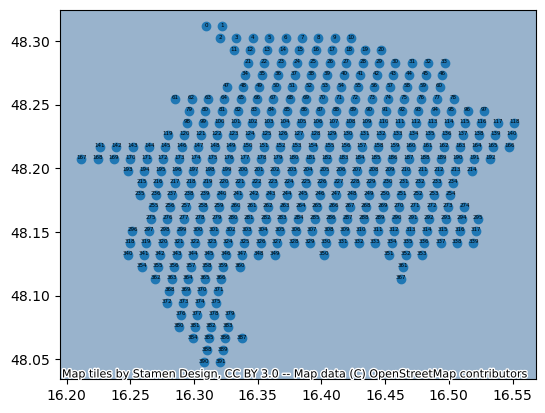

In [61]:
grouped_pid = isochrones.groupby('pid').apply(lambda x: x.iloc[0]).set_geometry('startpt')
ax = grouped_pid.plot()
# grouped_pid.apply(lambda x: ax.annotate(text=x['pid'], xy=x.startpt.coords[0], ha='center', fontsize=4), axis=1)
ctx.add_basemap(ax=ax, crs=grouped_pid.crs, zoom=12);

In [43]:
cached['pid'] = cached.uid.str.extract(r"\d*-(\d*)-\w*")
points = np.random.choice(cached.pid.unique(), 5)
points

array(['157', '235', '75', '216', '284'], dtype=object)

In [101]:
sizes = cached.groupby('pid').size()
cached2 = cached[cached.pid.isin(sizes[sizes == 30].index)]
print(cached2.pid.unique())
cached2

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23']


uid  tt_mnts                     dep_dt   
0            2167-0-driving-5m-v0        5  2023-06-13 08:30:37+02:00  \
1       2167-0-transit-peak-5m-v0        5  2023-06-13 08:30:37+02:00   
2            2167-0-transit-5m-v0        5  2023-06-13 13:00:37+02:00   
3            2167-0-cycling-5m-v0        5  2023-06-13 13:00:37+02:00   
4            2167-0-walking-5m-v0        5  2023-06-13 08:30:37+02:00   
...                           ...      ...                        ...   
2471   2167-23-driving-free-5m-v0        5        2023-05-02 08:30:37   
2472  2167-23-driving-free-15m-v0       15        2023-05-02 08:30:37   
2473  2167-23-driving-free-25m-v0       25        2023-05-02 08:30:37   
2474  2167-23-driving-free-35m-v0       35        2023-05-02 08:30:37   
2475  2167-23-driving-free-45m-v0       45        2023-05-02 08:30:37   

         mode                                          isochrone source pid  
0     driving  POLYGON ((4.78821 52.51372, 4.78832 52.51392, ...      g   0  
1     transit  MULTIPOLYGON (((4.78161 52.51684, 4.78161 52.5...      g   0  
2     transit  MULTIPOLYGON (((4.78161 52.51684, 4.78161 52.5...      g   0  
3     cycling  POLYGON ((4.78982 52.51794, 4.78952 52.51820, ...      g   0  
4     walking  POLYGON ((4.78176 52.51668, 4.78196 52.51677, ...      g   0  
...       ...                                                ...    ...  ..  
2471  driving  MULTIPOLYGON (((4.80538 52.45975, 4.80609 52.4...      b  23  
2472  driving  MULTIPOLYGON (((4.72238 52.51016, 4.72596 52.5...      b  23  
2473  driving  MULTIPOLYGON (((4.59909 52.49159, 4.60597 52.4...      b  23  
2474  driving  MULTIPOLYGON (((4.40086 52.13916, 4.40321 52.1...      b  23  
2475  driving  MULTIPOLYGON (((4.24766 52.02948, 4.26860 52.0...      b  23  

[720 rows x 7 columns]

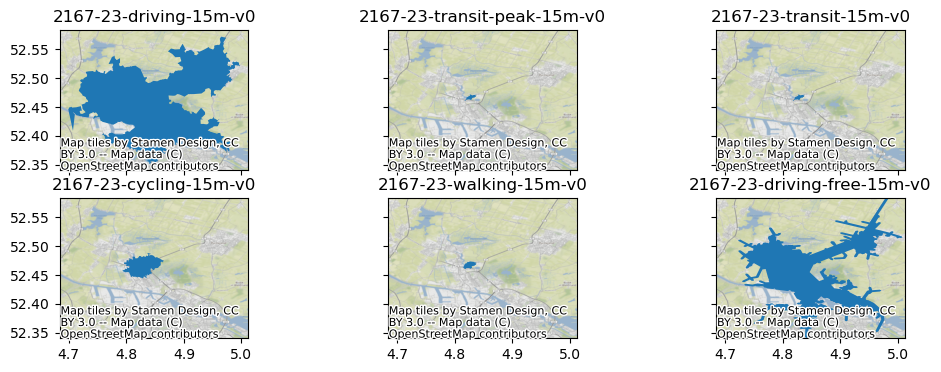

In [114]:
sel = cached[(cached.pid == '23') & (cached.tt_mnts == 15)]
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 4), sharex=True, sharey=True)

for n in range(len(sel)):
    ax = axs[n//3,n%3]
    sel.iloc[n:n+1].plot(ax=ax)
    ax.set_title(sel.iloc[n].uid)
    ctx.add_basemap(ax=ax, crs=sel.crs)


uid  pid                    startpt  tt_mnts   
400       3027-80-driving-25m-v0   80  POINT (16.30891 48.24531)       25  \
401  3027-80-transit-peak-25m-v0   80  POINT (16.30891 48.24531)       25   
402       3027-80-transit-25m-v0   80  POINT (16.30891 48.24531)       25   
403       3027-80-cycling-25m-v0   80  POINT (16.30891 48.24531)       25   
404       3027-80-walking-25m-v0   80  POINT (16.30891 48.24531)       25   

        mode      modetime                    dep_dt   
400  driving       driving 2023-06-13 08:30:37+02:00  \
401  transit  transit-peak 2023-06-13 08:30:37+02:00   
402  transit       transit 2023-06-13 13:00:37+02:00   
403  cycling       cycling 2023-06-13 13:00:37+02:00   
404  walking       walking 2023-06-13 08:30:37+02:00   

                                             isochrone  
400  POLYGON ((592670.384 5347989.466, 592167.602 5...  
401  MULTIPOLYGON (((594862.100 5343779.312, 594872...  
402  MULTIPOLYGON (((594665.973 5343751.293, 594805...  
403  POLYGON ((597422.695 5346727.831, 597543.251 5...  
404  POLYGON ((595895.976 5343877.405, 596001.131 5...

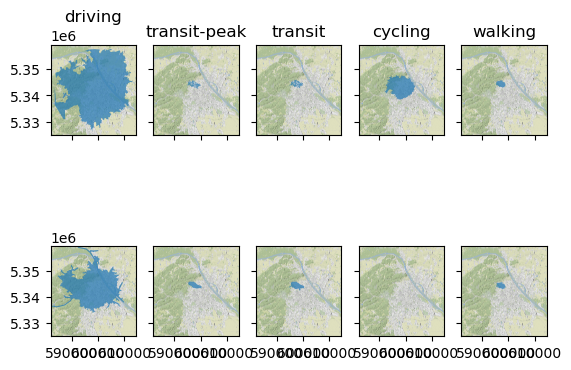

In [9]:
sample = isochrones.set_geometry('isochrone')[isochrones.pid == 80]
sample_bing = isochrones_bing.set_geometry('isochrone')[isochrones_bing.pid == 80]

sample.isochrone = sample.isochrone.to_crs(sample.isochrone.estimate_utm_crs()).simplify(tolerance=50)
sample_bing.isochrone = sample_bing.isochrone.to_crs(sample_bing.isochrone.estimate_utm_crs()).simplify(tolerance=50)

fig, axs = plt.subplots(ncols=5, nrows=2, sharey=True, sharex=True)
for i, (rid, row) in enumerate(sample.iterrows()):
    gpd.GeoSeries([row.isochrone]).plot(alpha=0.7, ax=axs[0][i])
    ctx.add_basemap(ax=axs[0][i], crs=sample.crs, attribution='', zoom=14)
    axs[0][i].set_title(row.modetime)
    
for i, (rid, row) in enumerate(sample_bing.iterrows()):
    gpd.GeoSeries([row.isochrone]).plot(alpha=0.7, ax=axs[1][i])
    ctx.add_basemap(ax=axs[1][i], crs=sample.crs, attribution='', zoom=14)
sample

KeyboardInterrupt: 

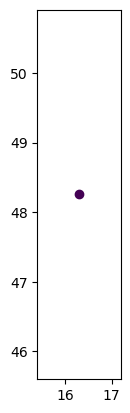

In [5]:
isochrones['surface'] = isochrones.set_geometry('isochrone').to_crs(isochrones.estimate_utm_crs()).area
ax = isochrones.iloc[250:251].set_geometry('startpt').plot(column='surface')
ctx.add_basemap(ax=ax, crs=isochrones.crs, zoom=12)

In [ ]:
# Analysis of reach during off-peak and on-peak times
offpeak = isochrones[(isochrones.modetime == 'transit') & (isochrones.tt_mnts==15)
                    ].to_crs(isochrones.estimate_utm_crs()).area

onpeak  = isochrones[(isochrones.modetime == 'transit-peak') & (isochrones.tt_mnts==15)
                    ].to_crs(isochrones.estimate_utm_crs()).area
bins = np.linspace(0, 8e6, 17)
plt.hist([offpeak, onpeak], bins, label=['off', 'on'], )

In [ ]:
w = isochrones
w['area'] = isochrones.to_crs(isochrones.estimate_utm_crs()).area
wew = w.groupby('pid').area.sum()

ax = w[w.pid.isin(list(wew[wew < 100].index))].set_geometry('startpt').plot()
ctx.add_basemap(ax, crs=w.crs)

In [ ]:
fig, axs = plt.subplots(ncols=5, figsize=(20, 4))
for i, t in enumerate(range(5, 55, 10)):
    stockholm = client.get_isochrone(STADSHUSET, f'stockholm-{t}', t, STARTDATE, 'driving')
    stockholm.plot(ax=axs[i])
    ctx.add_basemap(axs[i], crs="EPSG:4326")

In [ ]:
f1 = isochrones[(isochrones.tt_mnts == 25) & (isochrones['modetime'] == 'driving-peak')]
f1.sample(10)

uid  pid   
1417  2973-283-driving-peak-25m-v0  283  \
1072  2973-214-driving-peak-25m-v0  214   
292    2973-58-driving-peak-25m-v0   58   
867   2973-173-driving-peak-25m-v0  173   
167    2973-33-driving-peak-25m-v0   33   
72     2973-14-driving-peak-25m-v0   14   
1182  2973-236-driving-peak-25m-v0  236   
497    2973-99-driving-peak-25m-v0   99   
752   2973-150-driving-peak-25m-v0  150   
1397  2973-279-driving-peak-25m-v0  279   

                                            startpt  tt_mnts     mode   
1417     POINT (18.01459161404402 59.2778717596768)       25  driving  \
1072   POINT (18.180824235970285 59.31942546516677)       25  driving   
292     POINT (17.809407914986245 59.3921888249154)       25  driving   
867     POINT (18.15746029047635 59.34020922644428)       25  driving   
167   POINT (17.907861413584452 59.412988757317855)       25  driving   
72     POINT (17.838611689805763 59.43379332283908)       25  driving   
1182   POINT (18.162066230052076 59.30903531272011)       25  driving   
497     POINT (17.92433035841332 59.37139351993459)       25  driving   
752    POINT (18.100085241369325 59.35060283668956)       25  driving   
1397    POINT (17.953757197449526 59.2778717596768)       25  driving   

          modetime              dep_dt   
1417  driving-peak 2023-05-02 08:30:37  \
1072  driving-peak 2023-05-02 08:30:37   
292   driving-peak 2023-05-02 08:30:37   
867   driving-peak 2023-05-02 08:30:37   
167   driving-peak 2023-05-02 08:30:37   
72    driving-peak 2023-05-02 08:30:37   
1182  driving-peak 2023-05-02 08:30:37   
497   driving-peak 2023-05-02 08:30:37   
752   driving-peak 2023-05-02 08:30:37   
1397  driving-peak 2023-05-02 08:30:37   

                                               geometry  
1417  POLYGON ((17.54528 59.18718, 17.54516 59.18729...  
1072  POLYGON ((17.69975 59.20760, 17.69958 59.20770...  
292   POLYGON ((17.49665 59.58740, 17.49655 59.58752...  
867   POLYGON ((17.82625 59.45413, 17.82623 59.45427...  
167   POLYGON ((17.44467 59.59687, 17.44456 59.59699...  
72    POLYGON ((17.36948 59.62607, 17.36938 59.62619...  
1182  POLYGON ((17.67688 59.20639, 17.67682 59.20652...  
497   POLYGON ((17.48820 59.59046, 17.48814 59.59059...  
752   POLYGON ((17.65111 59.52335, 17.65107 59.52348...  
1397  POLYGON ((17.47934 59.18596, 17.47919 59.18607...

In [ ]:
# peak = f1[f1['modetime'] == 'driving-peak']
# offp = f1[f1['modetime'] == 'driving']

# fig, axs = plt.subplots(ncols=2, figsize=(10,5))
# peak.plot(ax=axs[0], color='red', alpha=0.5)
# offp.plot(ax=axs[1], color='blue', alpha=0.5)

# ctx.add_basemap(ax=axs[0], crs=isochrones.crs)
# ctx.add_basemap(ax=axs[1], crs=isochrones.crs)

In [ ]:
f1['reach_drive'] = f1.geometry.apply(lambda isoch: gdf[gdf.intersects(isoch)].cell_pop.sum())
f1.head()

/Users/ivo/opt/anaconda3/envs/DUTTv2/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


uid  pid   
2   2973-0-driving-peak-25m-v0    0  \
7   2973-1-driving-peak-25m-v0    1   
12  2973-2-driving-peak-25m-v0    2   
17  2973-3-driving-peak-25m-v0    3   
22  2973-4-driving-peak-25m-v0    4   

                                         startpt  tt_mnts     mode   
2   POINT (17.803324010715333 59.46500887070904)       25  driving  \
7   POINT (17.818586183034853 59.46500887070904)       25  driving   
12  POINT (17.784571631772113 59.45460252718758)       25  driving   
17  POINT (17.799830809491347 59.45460252718758)       25  driving   
22  POINT (17.815089987210587 59.45460252718758)       25  driving   

        modetime              dep_dt   
2   driving-peak 2023-05-02 08:30:37  \
7   driving-peak 2023-05-02 08:30:37   
12  driving-peak 2023-05-02 08:30:37   
17  driving-peak 2023-05-02 08:30:37   
22  driving-peak 2023-05-02 08:30:37   

                                             geometry  reach_drive  
2   POLYGON ((17.21427 59.64009, 17.21412 59.64020...          0.0  
7   POLYGON ((17.16985 59.64568, 17.16971 59.64580...          0.0  
12  POLYGON ((17.35538 59.62720, 17.35526 59.62732...          0.0  
17  POLYGON ((17.29834 59.63244, 17.29820 59.63255...          0.0  
22  POLYGON ((17.35112 59.62763, 17.35099 59.62775...          0.0

In [ ]:
f1 = f1.merge(gdf.reset_index(), left_on='pid', right_on='index', suffixes=('', '_gdf'))

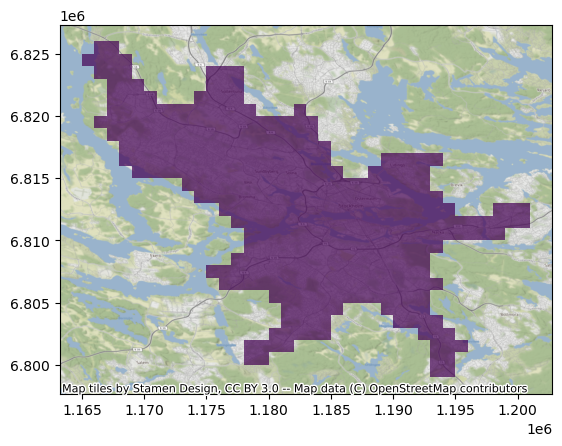

In [ ]:
ax = f1.set_geometry('geometry_gdf').plot(column='reach_drive', alpha=0.7)
ctx.add_basemap(ax=ax, crs=f1.set_geometry('geometry_gdf').crs)

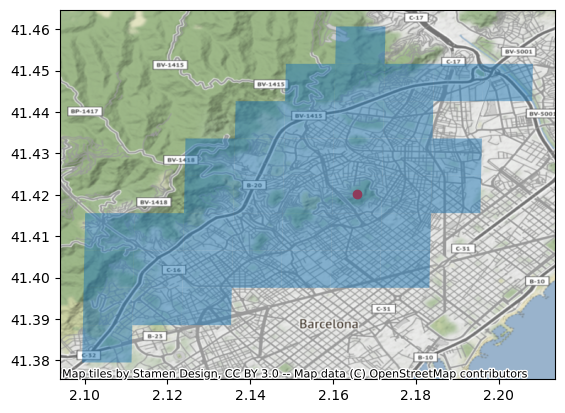

In [ ]:
gdf = gdf.to_crs("EPSG:4326")
ax = f1.set_geometry('startpt').iloc[:1].plot(color='red')
gdf[gdf.intersects(f1.iloc[0].geometry)].plot(ax=ax, alpha=0.5)
ctx.add_basemap(ax=ax, crs=gdf.crs)

<Axes: >

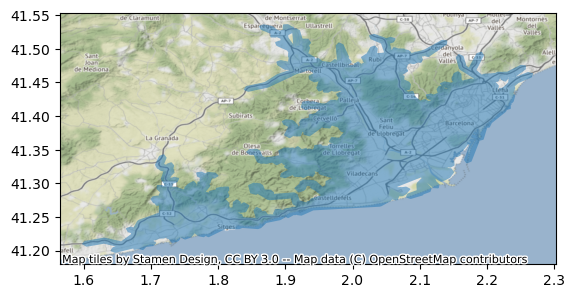

In [ ]:
marta_plot = isochrones.sample(1).plot(alpha=0.5)
ctx.add_basemap(ax=marta_plot, crs=isochrones.crs)
marta_plot